In [1]:
# imports

## allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys
import os

os.environ["POLARS_ALLOW_FORKING_THREAD"] = "1"

from tnibs.user import *

if ".." not in sys.path:
    sys.path.insert(0, "..")

logger = logging.getLogger()
logger.setLevel(level=logging.WARN)

__builtins__.verbosity = 4


In [2]:
# Declare a few global data/train params
class params:
    batch_size = 10000
    ic = (1, 0)
    w_0 = 1
    gamma = 0.1
    t_span = (0, 10)
    points = 1000

    lr = 0.001
    max_epochs = 100

    hidden_size = 64
    n_blks = 1
    dropout = 0.1



Loader 0 (1 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([833, 1]), torch.float32
batch[1]: torch.Size([833, 1]), torch.float32

First 2 samples:

Sample 0: 

9.089089393615723

-0.35873478651046753

Sample 1: 

4.264264106750488

-0.35327672958374023

Loader 1 (1 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([167, 1]), torch.float32
batch[1]: torch.Size([167, 1]), torch.float32

First 2 samples:

Sample 0: 

0.0

1.0

Sample 1: 

0.01001000963151455

0.9999499320983887


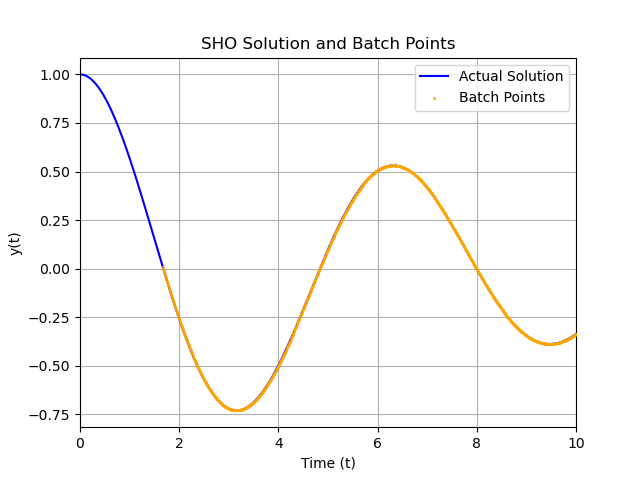

In [3]:
from examples.data.SHO import *

plt.close("all")
dt = SHO(SHOConfig.create(params, shuffle=True))

dt.preview(samples=2)
dt.draw_points()

In [4]:
# setup


def eval_model(trainer: Trainer, **kwargs):
    dt = SHO(SHOConfig.create(params, shuffle=False, t_span=(0, 15)))
    out = trainer.eval(
        pred=True, loss=False, **kwargs, loader=dt.loaders(shuffle=False)[0]
    )
    pred_array = out["preds"][0][0]
    dt.draw_points(
        (
            dt.data_range(0, 0),
            pred_array,
        )
    )
    out = trainer.eval(
        pred=True,
        loss=False,
        **kwargs,
    )
    pred_array = out["preds"][0][0]
    dt.draw_points(
        (
            dt.data_range(loader_index=1, batch_index=0),
            pred_array,
        )
    )


# time points at which to evaluate physics loss
t_eval = (
    torch.linspace(*params.t_span, 3 * params.batch_size)
    .reshape(-1, 1)
    .to(device)
    .requires_grad_(True)
)


def scheduler(optimizer, ts_opts: TrainerSchedulerOpts):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.1,
        steps_per_epoch=ts_opts.steps_per_epoch,
        epochs=ts_opts.epochs,
    )

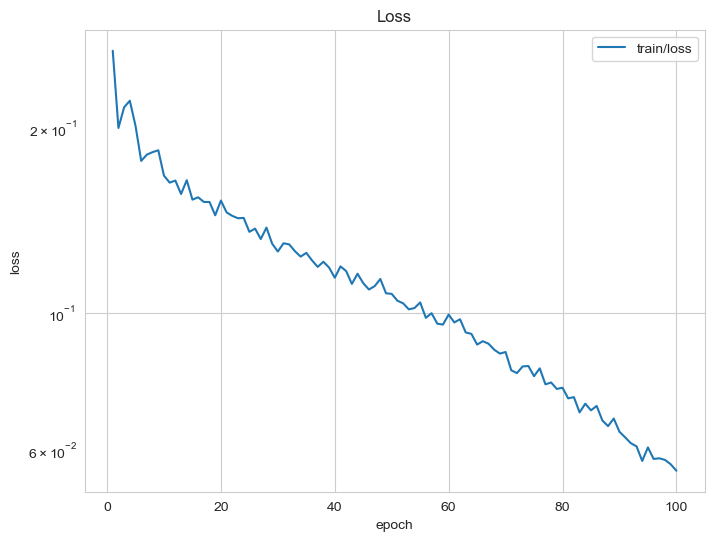

Epochs progress:   0%|          | 0/100 [00:00<?, ?Epoch/s]

/home/archr/gh/torch_nibs/.pixi/envs/dev/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1733624414920/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.2363, device='cuda:0')

In [9]:
# train without params
from examples.models.PINN import *

plt.close("all")

model_config = MLPPINNConfig.create(params, eq=dt.eq, t_eval=t_eval, activation=nn.GELU)

model = MLPPINN(model_config)
trainer = Trainer(TrainerConfig.create(params))
trainer.fit(model, dt.loaders())


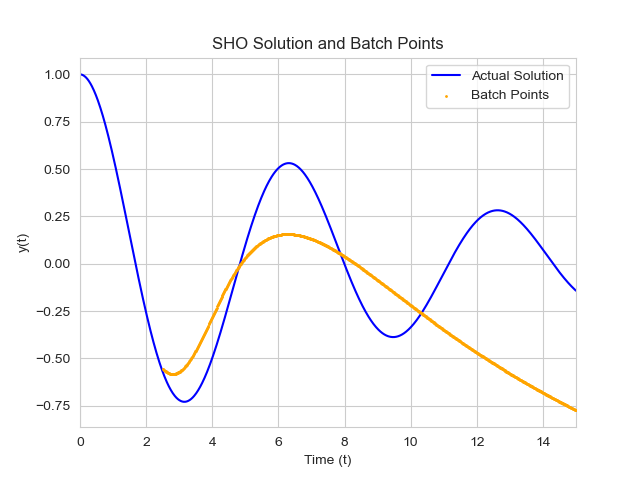

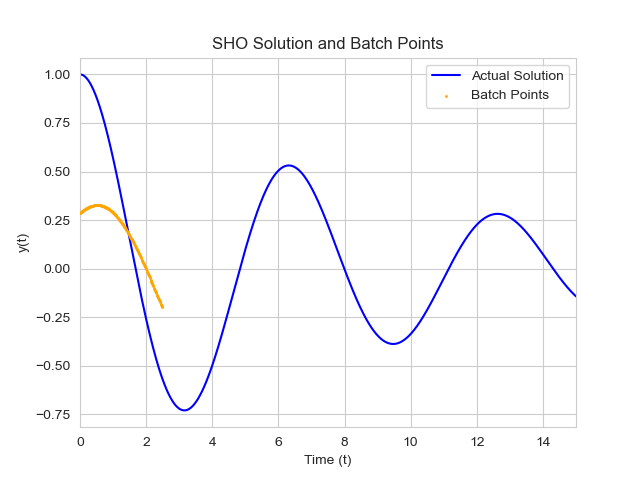

In [14]:
eval_model(trainer)


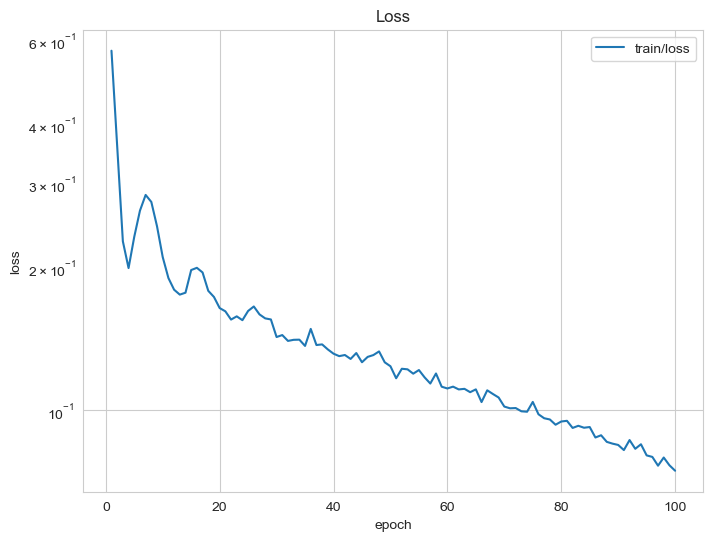

Epochs progress:   0%|          | 0/100 [00:00<?, ?Epoch/s]

/home/archr/gh/torch_nibs/.pixi/envs/dev/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1733624414920/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.4723, device='cuda:0')

In [5]:
from tnibs.utils.torch_utils import _grad
from examples.models.PINN import *

plt.close("all")


w_0 = nn.Parameter(torch.ones(1, requires_grad=True, device=device))
gamma = nn.Parameter(torch.ones(1, requires_grad=True, device=device))


def eq(model, t_eval):
    with torch.set_grad_enabled(True):
        y = model.forward(t_eval)
        y_t = _grad(y, t_eval)
        y_tt = _grad(y_t, t_eval)
        errs = y_tt - 2 * gamma * y_t - w_0**2 * y
        return errs


model = MLPPINN(
    MLPPINNConfig.create(
        params, eq=eq, t_eval=t_eval, activation=nn.GELU, p_params=[w_0, gamma]
    )
)

w_0s = []
gammas = []


def track():
    w_0s.append(w_0.data)
    gammas.append(gamma.data)


trainer = Trainer(
    TrainerConfig.create(
        params,
        epoch_end_callback=track,
    )
)
trainer.fit(model, dt.loaders())


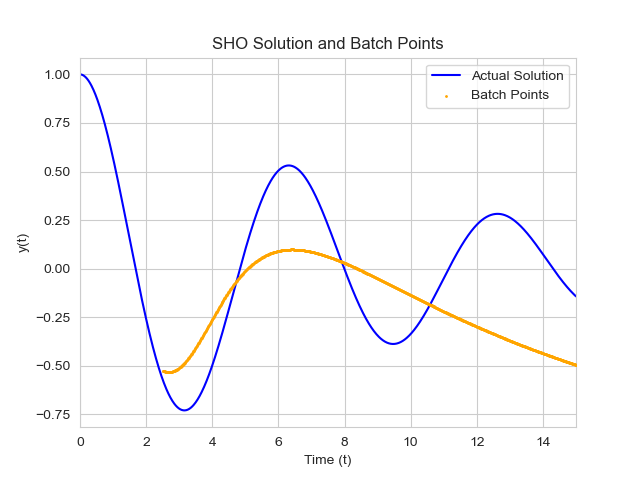

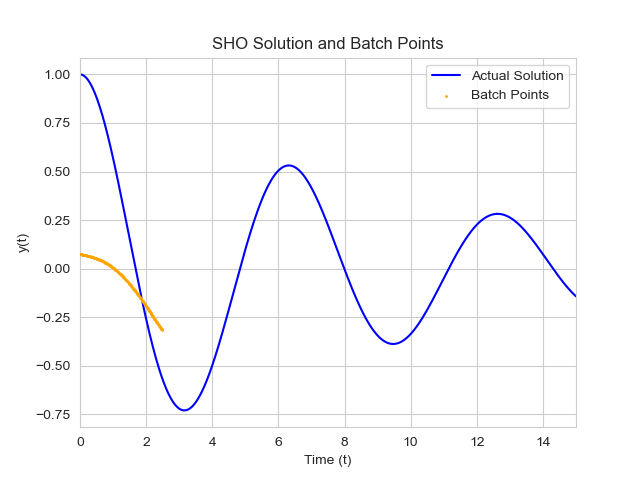

[tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0'), tensor([0.9223], device='cuda:0')]
[tensor([0.8886], device='cuda:0'), tensor([0.8886], device='cuda:0'), tensor([0.8886], device='cuda:0'), tensor([0.8886], device='cuda:0'), tensor([0.8886], device='cuda:0'), tensor([0.8886], device='cuda:0'), tensor([0.8886], device='cuda:0'), tensor([0.8886], device='cuda:0'), tensor([0.8886], d

In [6]:
from examples.data.SHO import *

plt.close("all")
eval_model(trainer)
print(w_0s[::10])
print(gammas[::10])
